### ARIMA-TimeSeries Analysis of Tractor Sales

In this case study example, we will learn about time series analysis for a manufacturing operation. Time series analysis and modeling have many business and social applications. It is extensively used to forecast company sales, product demand, stock market trends, agricultural production etc.

The fundamental idea for time series analysis is to decompose the original time series (sales, stock market trends, etc.) into several independent components. Typically, business time series are divided into the following four components:

- Trend – overall direction of the series i.e. upwards, downwards etc.
- Seasonality – monthly or quarterly patterns
- Cycle – long-term business cycles, they usually come after 5 or 7 years
- Irregular remainder – random noise left after extraction of all the components

Interference of these components produces the final series.

Why bother decomposing the original / actual time series into components? It is much easier to forecast the individual regular patterns produced through decomposition of time series than the actual series.

#### Step 0: Problem Definition
PowerHorse, a tractor and farm equipment manufacturing company, was established a few years after World War II. The company has shown a consistent growth in its revenue from tractor sales since its inception. However, over the years the company has struggled to keep it’s inventory and production cost down because of variability in sales and tractor demand. The management at PowerHorse is under enormous pressure from the shareholders and board to reduce the production cost. Additionally, they are also interested in understanding the impact of their marketing and farmer connect efforts towards overall sales. In the same effort, they have hired us as a data science and predictive analytics consultant.

We will develop an ARIMA model to forecast sale / demand of tractor for next 3 years. Additionally, We will also investigate the impact of marketing program on sales by using an exogenous variable ARIMA model.

As a part of this project, one of the production units we are analysing is based in South East Asia. This unit is completely independent and caters to neighbouring geographies. This unit is just a decade and a half old. In 2014 , they captured 11% of the market share, a 14% increase from the previous year. However, being a new unit they have very little bargaining power with their suppliers to implement Just-in-Time (JiT) manufacturing principles that have worked really well in PowerHorse’s base location. Hence, they want to be on top of their production planning to maintain healthy business margins. Monthly sales forecast is the first step we have suggested to this unit towards effective inventory management.

The MIS team shared the month on month (MoM) sales figures (number of tractors sold) for the last 12 years in the tractor-sales.csv file.

## Importing necessary packages

In [1]:
import warnings
import itertools

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('bmh')

#### Step 1: Visualize Tractor Sales data as time series

In [2]:
sales_data = pd.read_csv("E:/Tractor-Sales.csv")
sales_data.head(5)

,Month-Year,Number of Tractor Sold
0,Jan-03,141
1,Feb-03,157
2,Mar-03,185
3,Apr-03,199
4,May-03,203


In [3]:
sales_data.tail()

,Month-Year,Number of Tractor Sold
139,Aug-14,848
140,Sep-14,640
141,Oct-14,581
142,Nov-14,519
143,Dec-14,605


In [3]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
Month-Year                144 non-null object
Number of Tractor Sold    144 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.3+ KB


In [10]:
# since the complete date was not mentioned, we assume that it was the first of every month
dates = pd.date_range(start='2003-01-01', freq='MS', periods=len(sales_data))

In [47]:
import calendar
#calendar(2012)
sales_data['Month'] = dates.month
sales_data['Month'] = sales_data['Month'].apply(lambda x: calendar.month_abbr[x])
sales_data['Year'] = dates.year

In [48]:
sales_data.head()

,Month-Year,Number of Tractor Sold,Month,Year
0,Jan-03,141,Jan,2003
1,Feb-03,157,Feb,2003
2,Mar-03,185,Mar,2003
3,Apr-03,199,Apr,2003
4,May-03,203,May,2003


In [55]:
sales_data.drop(['Month-Year'], axis=1, inplace=True)
sales_data.rename(columns={'Number of Tractor Sold':'Tractor-Sales'}, inplace=True)
sales_data = sales_data[['Month', 'Year', 'Tractor-Sales']]

In [11]:
sales_data.head()

,Month,Year,Tractor-Sales
0,Jan,2003,141
1,Feb,2003,157
2,Mar,2003,185
3,Apr,2003,199
4,May,2003,203


In [12]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
Month            144 non-null object
Year             144 non-null int64
Tractor-Sales    144 non-null int64
dtypes: int64(2), object(1)
memory usage: 3.5+ KB


In [56]:
# set the dates as the index of the dataframe, so that it can be treated as a time-series dataframe
sales_data.set_index(dates, inplace=True)

In [57]:
# check out first 5 samples of the data
sales_data.head(5)

,Month,Year,Tractor-Sales
2003-01-01,Jan,2003,141
2003-02-01,Feb,2003,157
2003-03-01,Mar,2003,185
2003-04-01,Apr,2003,199
2003-05-01,May,2003,203


In [15]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 2003-01-01 to 2014-12-01
Freq: MS
Data columns (total 3 columns):
Month            144 non-null object
Year             144 non-null int64
Tractor-Sales    144 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.5+ KB


In [58]:
# extract out the time-series
sales_ts = sales_data['Tractor-Sales']

In [17]:
sales_ts.head()

2003-01-01    141
2003-02-01    157
2003-03-01    185
2003-04-01    199
2003-05-01    203
Freq: MS, Name: Tractor-Sales, dtype: int64

Text(0, 0.5, 'Tractor Sales')

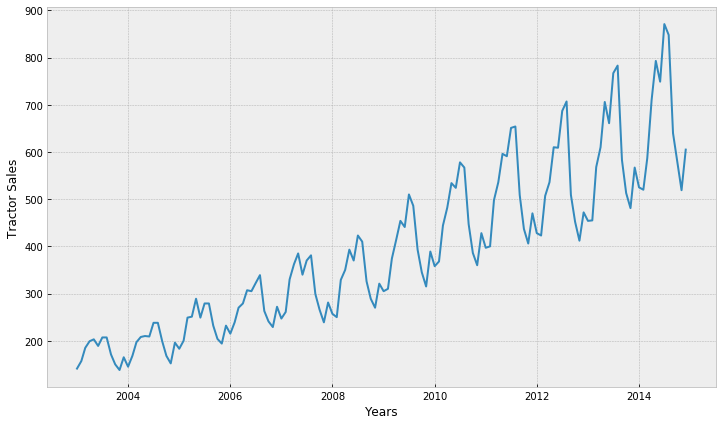

In [61]:
plt.figure(figsize=(12, 7))
plt.plot(sales_ts)
plt.xlabel('Years')
plt.ylabel('Tractor Sales')

Now we start with time series decomposition of this data to understand underlying patterns such as trend, seasonality, cycle and irregular remainder for tractor sales.

In the above data, a cyclic pattern seems to be non-existent since the unit we are analysing is a relatively new unit to notice business cycles. Also in theory, business cycles in traditional businesses are observed over a period of 7 or more years. Hence, we won’t include business cycles in this time series decomposition exercise. Also, we observe a overall increasing trend across years. We will build our model based on the following function:

- Yt=f(Trendt,Seasonalityt,Remaindert)
- Yt=f(Trendt,Seasonalityt,Remaindert)
 
Step 1.1: Trend - Time Series Decomposition
Now, to begin with let's try to decipher trends embedded in the above tractor sales time series. It is clearly evident that there is an overall increasing trend in the data along with some seasonal variations. However, it might not always be possible to make such visual inferences. So, more formally, we can check stationarity using the following:
Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. By moving average/variance we mean that at any instant 't', we'll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.
Moving Average - A good analogy for moving average is ironing clothes to remove wrinkles. The idea with moving average is to remove all the zigzag motion (wrinkles) from the time series to produce a steady trend through averaging adjacent values of a time period. Hence, the formula for moving average is:

MovingAverage=∑mi=−mYt+i2m
MovingAverage=∑i=−mmYt+i2m
 
Now, let’s try to remove wrinkles from our time series using moving average. We will take moving average of different time periods i.e. 4,6,8, and 12 months as shown below. Here, moving average is shown in red and actual series in blue.

In [62]:
sales_ts.head()

2003-01-01    141
2003-02-01    157
2003-03-01    185
2003-04-01    199
2003-05-01    203
Freq: MS, Name: Tractor-Sales, dtype: int64

In [70]:
sales_ts.rolling(window=4).mean()

2003-01-01       NaN
2003-02-01       NaN
2003-03-01       NaN
2003-04-01    170.50
2003-05-01    186.00
2003-06-01    194.00
2003-07-01    199.50
2003-08-01    201.50
2003-09-01    193.50
2003-10-01    183.75
2003-11-01    166.50
2003-12-01    156.00
2004-01-01    149.50
2004-02-01    154.00
2004-03-01    168.75
2004-04-01    179.50
2004-05-01    195.75
2004-06-01    206.00
2004-07-01    216.25
2004-08-01    223.75
2004-09-01    221.00
2004-10-01    210.75
2004-11-01    189.25
2004-12-01    178.75
2005-01-01    174.75
2005-02-01    182.75
2005-03-01    207.00
2005-04-01    220.75
2005-05-01    247.25
2005-06-01    259.50
               ...  
2012-07-01    610.50
2012-08-01    653.25
2012-09-01    628.00
2012-10-01    588.75
2012-11-01    520.00
2012-12-01    461.25
2013-01-01    447.50
2013-02-01    448.25
2013-03-01    487.25
2013-04-01    521.75
2013-05-01    584.75
2013-06-01    636.25
2013-07-01    686.00
2013-08-01    729.25
2013-09-01    698.50
2013-10-01    661.50
2013-11-01   

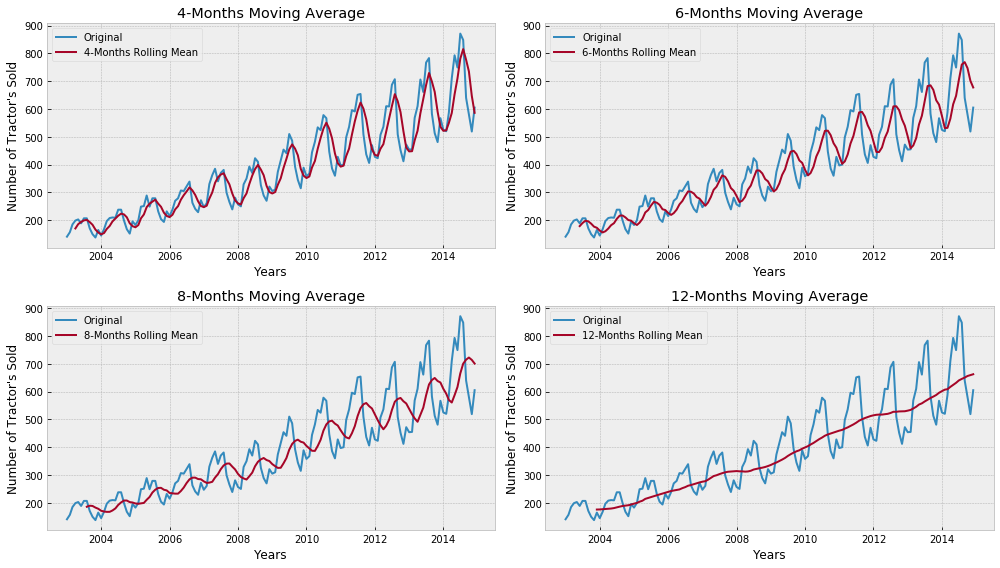

In [77]:
fig, axes = plt.subplots(2, 2)
fig.set_figwidth(14)
fig.set_figheight(8)

axes[0][0].plot(sales_ts.index, sales_ts, label='Original')
axes[0][0].plot(sales_ts.index, sales_ts.rolling(window=4).mean(), label='4-Months Rolling Mean')
axes[0][0].set_xlabel("Years")
axes[0][0].set_ylabel("Number of Tractor's Sold")
axes[0][0].set_title("4-Months Moving Average")
axes[0][0].legend(loc='best')

axes[0][1].plot(sales_ts.index, sales_ts, label='Original')
axes[0][1].plot(sales_ts.index, sales_ts.rolling(window=6).mean(), label='6-Months Rolling Mean')
axes[0][1].set_xlabel("Years")
axes[0][1].set_ylabel("Number of Tractor's Sold")
axes[0][1].set_title("6-Months Moving Average")
axes[0][1].legend(loc='best')

axes[1][0].plot(sales_ts.index, sales_ts, label='Original')
axes[1][0].plot(sales_ts.index, sales_ts.rolling(window=8).mean(), label='8-Months Rolling Mean')
axes[1][0].set_xlabel("Years")
axes[1][0].set_ylabel("Number of Tractor's Sold")
axes[1][0].set_title("8-Months Moving Average")
axes[1][0].legend(loc='best')

axes[1][1].plot(sales_ts.index, sales_ts, label='Original')
axes[1][1].plot(sales_ts.index, sales_ts.rolling(window=12).mean(), label='12-Months Rolling Mean')
axes[1][1].set_xlabel("Years")
axes[1][1].set_ylabel("Number of Tractor's Sold")
axes[1][1].set_title("12-Months Moving Average")
axes[1][1].legend(loc='best')

plt.tight_layout()
plt.show()

As we could see in the above plots, 12-month moving average could produce a wrinkle free curve as desired. This on some level is expected since we are using month-wise data for our analysis and there is expected monthly-seasonal effect in our data.

Let's plot the rolling mean and standard deviation on window of 12 months.

#### Step 1.2: Seasonality – Time Series Decomposition

The first thing to do is to see how number of tractors sold vary on a month on month basis. We will plot a stacked annual plot to observe seasonality in our data.

In [22]:
sales_data.head()

,Month,Year,Tractor-Sales
2003-01-01,Jan,2003,141
2003-02-01,Feb,2003,157
2003-03-01,Mar,2003,185
2003-04-01,Apr,2003,199
2003-05-01,May,2003,203


In [23]:
monthly_sales_data = pd.pivot_table(sales_data, values = "Tractor-Sales", columns = "Year", index = "Month")
monthly_sales_data = monthly_sales_data.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly_sales_data

Year,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Month,,,,,,,,,,,,
Jan,141,145,183,215,247,257,305,358,397,428,454,525
Feb,157,168,200,239,261,250,310,368,400,423,455,520
Mar,185,197,249,270,330,329,374,444,498,507,568,587
Apr,199,208,251,279,362,350,414,482,536,536,610,710
May,203,210,289,307,385,393,454,534,596,610,706,793
Jun,189,209,249,305,340,370,441,524,591,609,661,749
Jul,207,238,279,322,370,423,510,578,651,687,767,871
Aug,207,238,279,339,381,410,486,567,654,707,783,848
Sep,171,199,232,263,299,326,393,447,509,509,583,640


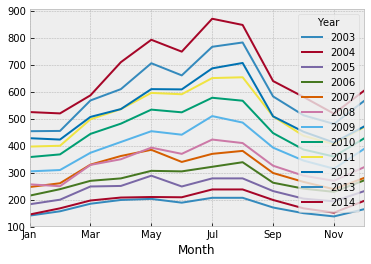

In [24]:
monthly_sales_data.plot()

In [25]:
yearly_sales_data = pd.pivot_table(sales_data, values = "Tractor-Sales", columns = "Month", index = "Year")
yearly_sales_data = yearly_sales_data[['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
yearly_sales_data

Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2003,141,157,185,199,203,189,207,207,171,150,138,165
2004,145,168,197,208,210,209,238,238,199,168,152,196
2005,183,200,249,251,289,249,279,279,232,204,194,232
2006,215,239,270,279,307,305,322,339,263,241,229,272
2007,247,261,330,362,385,340,370,381,299,266,239,281
2008,257,250,329,350,393,370,423,410,326,289,270,321
2009,305,310,374,414,454,441,510,486,393,345,315,389
2010,358,368,444,482,534,524,578,567,447,386,360,428
2011,397,400,498,536,596,591,651,654,509,437,406,470


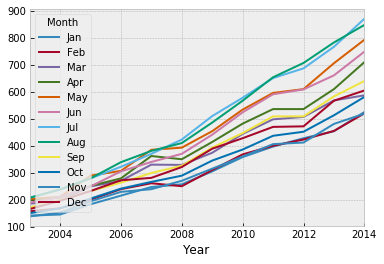

In [26]:
yearly_sales_data.plot()

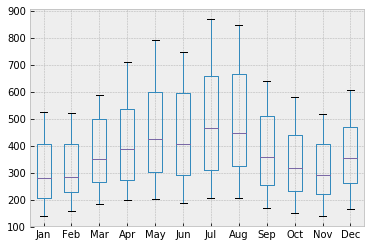

In [27]:
yearly_sales_data.boxplot()

#### Important Inferences

The tractor sales have been increasing without fail every year.

July and August are the peak months for tractor sales and the variance and the mean value in July and August are also much higher than any of the other months.

We can see a seasonal cycle of 12 months where the mean value of each month starts with a increasing trend in the beginning of the year and drops down towards the end of the year. We can see a seasonal effect with a cycle of 12 months.


#### Step 1.3: Irregular Remainder – Time Series Decomposition
To decipher underlying patterns in tractor sales, we build a multiplicative time series decomposition model with the following equation:

- Yt=Trendt×Seasonalityt×Remaindert
 
Instead of multiplicative model we could have chosen additive model as well. In that case the equaltion would have been:

- Yt=Trendt+Seasonalityt+Remaindert
 
However, it would have made very little difference in terms of conclusion we will draw from this time series decomposition exercise. Additionally, we are also aware that plain vanilla decomposition models like these are rarely used for forecasting. Their primary purpose is to understand underlying patterns in temporal data to use in more sophisticated analysis like Holt-Winters seasonal method or ARIMA.

In [28]:
sm.tsa.seasonal_decompose?

In [33]:
decomposition = sm.tsa.seasonal_decompose(sales_ts, model='multiplicative', extrapolate_trend=8)

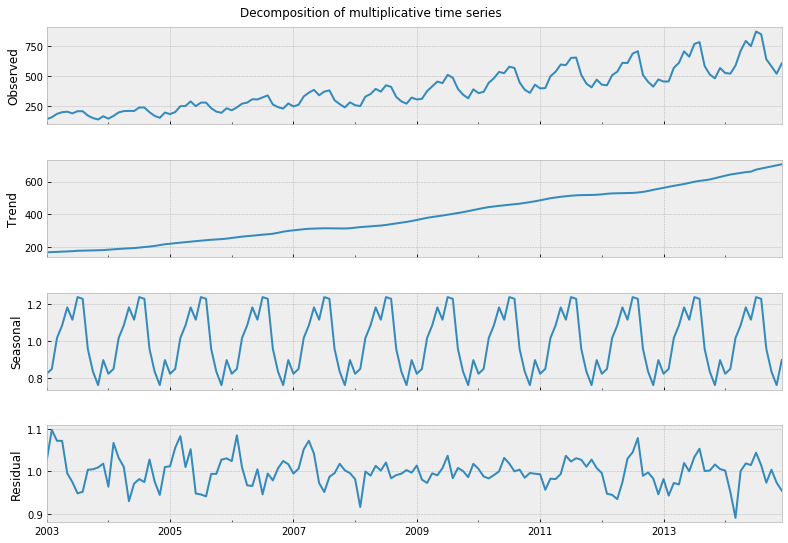

In [34]:
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

In [35]:
decomposition.trend

2003-01-01    166.803241
2003-02-01    168.170602
2003-03-01    169.537963
2003-04-01    170.905324
2003-05-01    172.272685
2003-06-01    173.640046
2003-07-01    176.166667
2003-08-01    176.791667
2003-09-01    177.750000
2003-10-01    178.625000
2003-11-01    179.291667
2003-12-01    180.416667
2004-01-01    182.541667
2004-02-01    185.125000
2004-03-01    187.583333
2004-04-01    189.500000
2004-05-01    190.833333
2004-06-01    192.708333
2004-07-01    195.583333
2004-08-01    198.500000
2004-09-01    202.000000
2004-10-01    205.958333
2004-11-01    211.041667
2004-12-01    216.000000
2005-01-01    219.375000
2005-02-01    222.791667
2005-03-01    225.875000
2005-04-01    228.750000
2005-05-01    232.000000
2005-06-01    235.250000
                 ...    
2012-07-01    530.416667
2012-08-01    532.833333
2012-09-01    536.708333
2012-10-01    542.333333
2012-11-01    549.416667
2012-12-01    555.583333
2013-01-01    561.083333
2013-02-01    567.583333
2013-03-01    573.833333


In [81]:
decomp_output = pd.DataFrame(pd.concat([decomposition.observed, decomposition.trend, decomposition.seasonal, decomposition.resid], axis=1))

In [82]:
decomp_output.columns = ['observed', 'Trend', 'Seasonal', 'Irregular']

In [83]:
decomp_output['TSI'] = decomp_output.Trend*decomp_output.Seasonal*decomp_output.Irregular

In [84]:
decomp_output

,observed,Trend,Seasonal,Irregular,TSI
2003-01-01,141,166.803241,0.823937,1.025937,141.0
2003-02-01,157,168.170602,0.850078,1.098223,157.0
2003-03-01,185,169.537963,1.017430,1.072507,185.0
2003-04-01,199,170.905324,1.085932,1.072248,199.0
2003-05-01,203,172.272685,1.183405,0.995741,203.0
2003-06-01,189,173.640046,1.116535,0.974854,189.0
2003-07-01,207,176.166667,1.239018,0.948350,207.0
2003-08-01,207,176.791667,1.229776,0.952100,207.0
2003-09-01,171,177.750000,0.958102,1.004095,171.0
2003-10-01,150,178.625000,0.835369,1.005242,150.0


### Forecasting using decomposition with the help of STLDECOMPOSE PACKAGE

In [29]:
#!pip install stldecompose
#import stldecompose as stl
# the main library has a small set of functionality
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive,
                                         drift, 
                                         mean, 
                                         seasonal_naive)

#### Decomposition

One of the primary pieces of functionality is the STL decomposition. The associated method requires the observation frame, and the primary (largest) period of seasonality. This period is specified in terms of index positions, and so care is needed for the user to correctly specify the periodicity in terms of their observations.

For example, with daily observations and large annual cycles, period=365. For hourly observations with large daily cycles, period=24. Some inspection, and trial and error may be helpful.

In [36]:
decomp = decompose(sales_ts, period=12)
decompose?

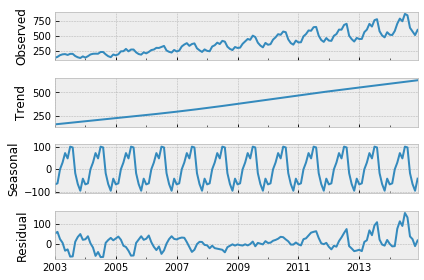

In [31]:
decomp.plot();

#### Forecast
While the STL decomposition is interesting on its own, STLDecompose also provides some relatively naive capabilities for using the decomposition to forecast based on our observations.

We'll use the same data set, but pretend that we only had the first two third of observations. Then we can compare our forecast to the real observation data.

The forecast() method requires the following arguments:

the previously fit DecomposeResult
the number of steps forward for which we'd like the forecast
the specific forecasting function to be applied to the decomposition
There are a handful of predefined functions that can be imported from the stldecompose.forecast_funcs module.

In [34]:
fcast = forecast(decomp, steps=36, fc_func=drift, seasonal=True)

fcast

,drift+seasonal
2014-12-31,565.979215
2015-01-30,574.072482
2015-03-01,639.745165
2015-03-31,673.076709
2015-04-30,718.397706
2015-05-30,698.206521
2015-06-29,753.763785
2015-07-29,753.474031
2015-08-28,642.845684
2015-09-27,597.966254


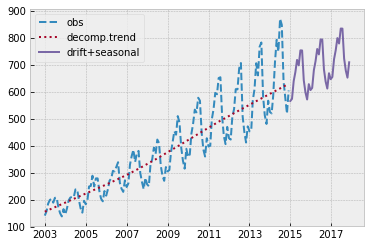

In [35]:
plt.plot(sales_ts, '--', label='obs')
plt.plot(decomp.trend, ':', label='decomp.trend')
plt.plot(fcast, '-', label=fcast.columns[0])

plt.legend();

### Dickey-Fuller Test 
- Let's run the Dicky Fuller Test on the timeseries and verify the null hypothesis that the TS is non-stationary.

In [37]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
adfuller(sales_ts)

(1.1088250591467375,
 0.995291241524842,
 14,
 129,
 {'1%': -3.482087964046026,
  '5%': -2.8842185101614626,
  '10%': -2.578864381347275},
 1082.5357724796872)

In [38]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_ts)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   1.108825
p-value                          0.995291
#lags Used                      14.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


Though the variation in standard deviation is small, rolling mean is clearly increasing with time and this is not a stationary series. Also, the test statistic is way more than the critical values.

As we observed while plotting the moving average over months that there is a monhly pattern, now, let’s decipher the seasonal component.

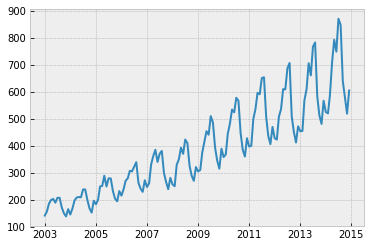

In [44]:
plt.plot(sales_ts)

In [39]:
sales_ts_log = np.log10(sales_ts)

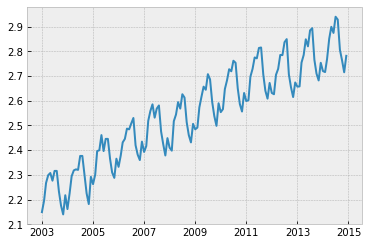

In [40]:
plt.plot(sales_ts_log)

In [41]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_ts_log)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -1.732472
p-value                          0.414464
#lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [48]:
sales_ts.head()

2003-01-01    141
2003-02-01    157
2003-03-01    185
2003-04-01    199
2003-05-01    203
Freq: MS, Name: Tractor-Sales, dtype: int64

In [42]:
sales_ts.diff(1).head()

2003-01-01     NaN
2003-02-01    16.0
2003-03-01    28.0
2003-04-01    14.0
2003-05-01     4.0
Freq: MS, Name: Tractor-Sales, dtype: float64

In [43]:
sales_ts_diff1 = sales_ts.diff(1)
sales_ts_diff1.dropna(inplace=True)

In [44]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_ts_diff1)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -2.543481
p-value                          0.105250
#lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [45]:
sales_ts_log_diff1 = sales_ts_log.diff(1)
sales_ts_log_diff1.dropna(inplace=True)

In [46]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_ts_log_diff1)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -2.680467
p-value                          0.077480
#lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [47]:
sales_ts_log_diff2 = sales_ts_log.diff(2)
sales_ts_log_diff2.dropna(inplace=True)

In [48]:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_ts_log_diff2)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -3.200722
p-value                          0.019943
#lags Used                      11.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


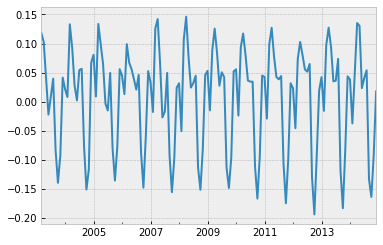

In [49]:
sales_ts_log_diff2.plot()

The following are some of our key observations from this analysis:
1) Trend: 12-months moving average looks quite similar to a straight line hence we could have easily used linear regression to estimate the trend in this data.
2) Seasonality: As discussed, seasonal plot displays a fairly consistent month-on-month pattern. The monthly seasonal components are average values for a month after removal of trend. Trend is removed from the time series using the following formula:

- Seasonalityt×Remaindert=YtTrendt

 
3) Irregular Remainder (random): is the residual left in the series after removal of trend and seasonal components. Remainder is calculated using the following formula:

- Remaindert=YtTrendt×Seasonalityt
 
The expectations from remainder component is that it should look like a white noise i.e. displays no pattern at all. However, for our series residual display some pattern with high variation on the edges of data i.e. near the beginning (2004-07) and the end (2013-14) of the series.

#### ARIMA Modeling
ARIMA is a combination of 3 parts i.e. AR (AutoRegressive), I (Integrated), and MA (Moving Average). A convenient notation for ARIMA model is ARIMA(p,d,q). Here p,d, and q are the levels for each of the AR, I, and MA parts. Each of these three parts is an effort to make the final residuals display a white noise pattern (or no pattern at all). In each step of ARIMA modeling, time series data is passed through these 3 parts like a sugar cane through a sugar cane juicer to produce juice-less residual. The sequence of three passes for ARIMA analysis is as following:

1st Pass of ARIMA to Extract Juice / Information
Integrated (I) – subtract time series with its lagged series to extract trends from the data
In this pass of ARIMA juicer, we extract trend(s) from the original time series data. Differencing is one of the most commonly used mechanisms for extraction of trends. Here, the original series is subtracted with it’s lagged series e.g. November’s sales values are subtracted with October’s values to produce trend-less residual series. The formulae for different orders of differencing are as follow:

- No Differencing (d=0) |  Y′t=YtYt′=Yt 
- 1st Differencing (d=1) |  Y′t=Yt−Yt−1Yt′=Yt−Yt−1 
- 2nd Differencing (d=1) |  Y′t=Yt−Yt−1−(Yt−1−Yt−2)=Yt−2×Yt−1+Yt−2Yt′=Yt−Yt−1−(Yt−1−Yt−2)=Yt−2×Yt−1+Yt−2 

For example, in the below plot a time series data with a linearly upward trend is displayed. Adjacent to that plot is the 1st order differenced plot for the same data. As we can notice after 1st order differencing, trend part of the series is extracted and the difference data (residual) does not display any trend.

#### Step 2: Difference data to make data stationary on mean (remove trend)
Clearly the tractor sales has an upward trend for tractors sales and there is also a seasonal component that we have already analyzed.

The next thing to do is to make the series stationary by removing the upward trend through 1st order differencing of the series using the following formula:

1st Differencing (d=1) |  Y′t=Yt−Yt−1

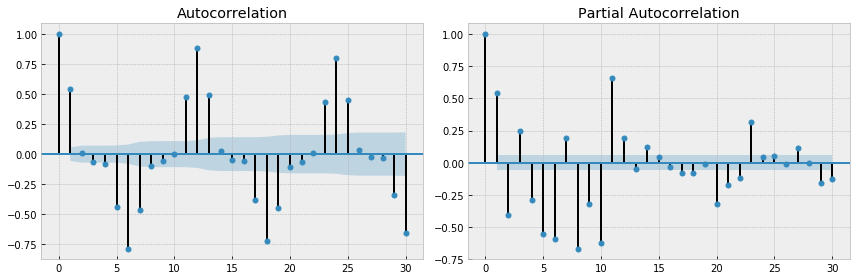

In [58]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(sales_ts_log_diff2, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(sales_ts_log_diff2, lags=30, ax=axes[1], alpha=0.5,method='ols')
plt.tight_layout()

Since, there are enough spikes in the plots outside the insignificant zone (dotted horizontal lines) we can conclude that the residuals are not random. This implies that there is juice or information available in residuals to be extracted by AR and MA models. Also, there is a seasonal component available in the residuals at the lag 12 (represented by spikes at lag 12). This makes sense since we are analyzing monthly data that tends to have seasonality of 12 months because of patterns in tractor sales.

#### Step 6: Identification of best fit ARIMA model

In order to fit the time series data with a seasonal ARIMA model, we need to first find the the values of ARIMA(p,d,q)(P,D,Q)s that optimize a metric of interest such as AIC or BIC. There are many guidelines and best practices to achieve this goal, yet the correct parametrization of ARIMA models can be a painstaking manual process that requires domain expertise and time. Auto arima function in forecast package in R helps us identify the best fit ARIMA model on the fly but in Python we will generate combination of p,d and q to select the optimal parameter values for our ARIMA(p,d,q)(P,D,Q)s time series model.
This technique is known as "grid search" where we iteratively explore different combinations of parameters. For each such combination of parameters, we try to fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess AIC or BIC score. The model with the best score wins and the parmeters for that model are the optimal parmeters.

In [53]:
sm.tsa.statespace.SARIMAX?

In [50]:
model = sm.tsa.statespace.SARIMAX(sales_ts_log_diff2, order = (1,2,1), seasonal_order= (1,0,0,12),
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)

In [51]:
results = model.fit()

In [52]:
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                      Tractor-Sales   No. Observations:                  142
Model:             SARIMAX(1, 2, 1)x(1, 0, 0, 12)   Log Likelihood                 279.836
Date:                            Sat, 27 Jul 2019   AIC                           -551.672
Time:                                    11:31:35   BIC                           -540.296
Sample:                                03-01-2003   HQIC                          -547.050
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0744      0.078     -0.949      0.343      -0.228       0.079
ma.L1         -1.0000    242.695   

### Iterate the process to find the best values for p, d, q and P, D, Q

In [53]:
# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 3)
d = range(2,3)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

In [54]:
pdq

[(0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [56]:
# Generate all different combinations of seasonal p, q and q triplets
D = range(0,2)
P = Q = range(0, 2) 
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]

In [57]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [59]:
import sys
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(sales_ts_log,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(1, 2, 1)x(1, 0, 1, 12)12 model - AIC:-673.284597171393


Best SARIMAX(1, 2, 1)x(1, 0, 1, 12)12 model - AIC:-673.2934415061015
The best fit model is selected based on Akaike Information Criterion (AIC) , and Bayesian Information Criterion (BIC) values. The idea is to choose a model with minimum AIC and BIC values.

#### Akaike Information Criterion (AIC) 
- AIC is an effort to balance the model between goodness-of-fit and number of parameters used in the model. This is similar to the balancing act between income and cost of a company so that the debs of the company is optimized (Debt = Cost - Income). As a modeler, we care about the maximum goodness of fit (income) with the minimum number of parameters (cost).

AIC=2K−2ln(L)AIC=2K−2ln(L) 

For the given model, L in the above formula is the maximized value of the likelihood function representing goodness-of-fit, and K the number of estimated parameters. Like our debts, we want to keep AIC value at the minimum to choose the best possible model. Bayesian Information Criterion (BIC) is another variant of AIC and is used for the same purpose of best fit model selection. For the best possible model selection, we want to look at AIC, BIC, and AICc (AIC with sample correction) if all these values are minimum for a given model. With increasing parameters K will increase and hence AIC increases. While with the goodness of the fit L increases thus decreasing AIC.

As expected, our model has I (or integrated) component equal to 1. This represents differencing of order 1. There is additional differencing of lag 12 in the above best fit model. Moreover, the best fit model has MA value of order 1. Also, there is seasonal MA with lag 12 of order 1.

The model that we got here is different from the one that was discussed in the blog. Let us validate that model with ours how does that perform with statsmodel as well as our model.

#### Step 7: Predict sales on in-sample date using the best fit ARIMA model
The next step is to predict tractor sales for in-sample data and find out how close is the model prediction on the in-sample data to the actual truth.

In [60]:
best_model = sm.tsa.statespace.SARIMAX(sales_ts_log,
                                      order=(1, 2, 1),
                                      seasonal_order=(1, 0, 1, 12),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
best_results = best_model.fit()

In [61]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                      Tractor-Sales   No. Observations:                  144
Model:             SARIMAX(1, 2, 1)x(1, 0, 1, 12)   Log Likelihood                 341.642
Date:                            Sat, 27 Jul 2019   AIC                           -673.285
Time:                                    11:42:06   BIC                           -659.024
Sample:                                01-01-2003   HQIC                          -667.491
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3575      0.072     -4.932      0.000      -0.500      -0.215
ma.L1         -0.9991      1.459   

In [78]:
sales_ts

2003-01-01    141
2003-02-01    157
2003-03-01    185
2003-04-01    199
2003-05-01    203
2003-06-01    189
2003-07-01    207
2003-08-01    207
2003-09-01    171
2003-10-01    150
2003-11-01    138
2003-12-01    165
2004-01-01    145
2004-02-01    168
2004-03-01    197
2004-04-01    208
2004-05-01    210
2004-06-01    209
2004-07-01    238
2004-08-01    238
2004-09-01    199
2004-10-01    168
2004-11-01    152
2004-12-01    196
2005-01-01    183
2005-02-01    200
2005-03-01    249
2005-04-01    251
2005-05-01    289
2005-06-01    249
             ... 
2012-07-01    687
2012-08-01    707
2012-09-01    509
2012-10-01    452
2012-11-01    412
2012-12-01    472
2013-01-01    454
2013-02-01    455
2013-03-01    568
2013-04-01    610
2013-05-01    706
2013-06-01    661
2013-07-01    767
2013-08-01    783
2013-09-01    583
2013-10-01    513
2013-11-01    481
2013-12-01    567
2014-01-01    525
2014-02-01    520
2014-03-01    587
2014-04-01    710
2014-05-01    793
2014-06-01    749
2014-07-01

In [62]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2014-01-01'), full_results=True)

In [63]:
pred_dynamic.predicted_mean

2014-01-01    2.723790
2014-02-01    2.723680
2014-03-01    2.809710
2014-04-01    2.812644
2014-05-01    2.888743
2014-06-01    2.885705
2014-07-01    2.933770
2014-08-01    2.942358
2014-09-01    2.808440
2014-10-01    2.747035
2014-11-01    2.725364
2014-12-01    2.790594
Freq: MS, dtype: float64

In [64]:
np.power(10, pred_dynamic.predicted_mean)

2014-01-01    529.407697
2014-02-01    529.273250
2014-03-01    645.222630
2014-04-01    649.597031
2014-05-01    774.003616
2014-06-01    768.608411
2014-07-01    858.558562
2014-08-01    875.705345
2014-09-01    643.338496
2014-10-01    558.515065
2014-11-01    531.329464
2014-12-01    617.439581
Freq: MS, dtype: float64

In [65]:
sales_ts['2014-01-01':]

2014-01-01    525
2014-02-01    520
2014-03-01    587
2014-04-01    710
2014-05-01    793
2014-06-01    749
2014-07-01    871
2014-08-01    848
2014-09-01    640
2014-10-01    581
2014-11-01    519
2014-12-01    605
Freq: MS, Name: Tractor-Sales, dtype: int64

In [65]:
forecast = np.power(10,pred_dynamic.predicted_mean)

In [66]:
actual = sales_ts['2014-01-01':]

In [67]:
#Mean absolute percentage error
MAPE_last1year = np.mean(np.abs(actual - forecast)/actual)

In [69]:
print('The Mean Absolute percentage error of our forecast for last two years is {}'.format(round(MAPE_last1year, 4)))


The Mean Absolute percentage error of our forecast for last two years is 0.033


In [70]:
# Compute the mean square error
mse = ((actual - forecast) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))
print('The ROOT Mean Squared Error of our forecasts is {}'.format(np.sqrt(round(mse, 4))))

The Mean Squared Error of our forecasts is 802.9182
The ROOT Mean Squared Error of our forecasts is 28.335811264193584


In [71]:
#Forecast for next 12 Months

In [72]:
np.power(10, best_results.forecast(steps=12))

2015-01-01    564.625936
2015-02-01    562.778100
2015-03-01    669.138981
2015-04-01    756.664898
2015-05-01    854.571853
2015-06-01    815.216892
2015-07-01    937.406526
2015-08-01    932.890508
2015-09-01    698.812587
2015-10-01    620.806246
2015-11-01    565.409201
2015-12-01    662.442349
Freq: MS, dtype: float64

#### Step 8: Forecast sales using the best fit ARIMA model
The next step is to predict tractor sales for next 3 years i.e. for 2015, 2016, and 2017 through the above model.

In [73]:
# Get forecast 36 steps (3 years) ahead in future
n_steps = 36
pred_uc_99 = best_results.get_forecast(steps=36, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=36, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [74]:
pred_ci_99.head()

,lower Tractor-Sales,upper Tractor-Sales
2015-01-01,2.720116,2.783406
2015-02-01,2.712551,2.788123
2015-03-01,2.780267,2.870765
2015-04-01,2.827830,2.929977
2015-05-01,2.875135,2.988362


In [75]:
pred_ci_95.head()

,lower Tractor-Sales,upper Tractor-Sales
2015-01-01,2.720116,2.783406
2015-02-01,2.712551,2.788123
2015-03-01,2.780267,2.870765
2015-04-01,2.827830,2.929977
2015-05-01,2.875135,2.988362


In [76]:
n_steps = 36
idx = pd.date_range(sales_ts.index[-1], periods=n_steps, freq='MS')
fc_95 = pd.DataFrame(np.column_stack([np.power(10, pred_uc_95.predicted_mean), np.power(10, pred_ci_95)]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([np.power(10, pred_ci_99)]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])

In [77]:
fc_95.head()

,forecast,lower_ci_95,upper_ci_95
2014-12-01,564.625936,524.947194,607.303842
2015-01-01,562.778100,515.883217,613.935828
2015-02-01,669.138981,602.930765,742.617564
2015-03-01,756.664898,672.713587,851.092915
2015-04-01,854.571853,750.127421,973.558666


In [78]:
fc_99.head()

,lower_ci_99,upper_ci_99
2014-12-01,524.947194,607.303842
2015-01-01,515.883217,613.935828
2015-02-01,602.930765,742.617564
2015-03-01,672.713587,851.092915
2015-04-01,750.127421,973.558666


In [79]:
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all.head()

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
2014-12-01,564.625936,524.947194,607.303842,524.947194,607.303842
2015-01-01,562.778100,515.883217,613.935828,515.883217,613.935828
2015-02-01,669.138981,602.930765,742.617564,602.930765,742.617564
2015-03-01,756.664898,672.713587,851.092915,672.713587,851.092915
2015-04-01,854.571853,750.127421,973.558666,750.127421,973.558666


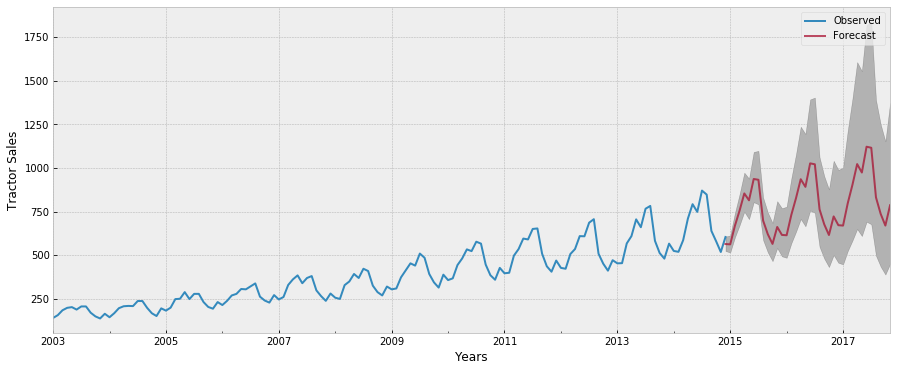

In [80]:
# plot the forecast along with the confidence band
axis = sales_ts.plot(label='Observed', figsize=(15, 6))
fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
#axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=.25)
axis.fill_between(fc_all.index, fc_all['lower_ci_99'], fc_all['upper_ci_99'], color='k', alpha=.25)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()

In [ ]:
#Diagnostics
    #1. Errors follows normality
    #2. Errors should not have auto correlation (ACF, no spikes beyond the limits)
    #3. Errors should not have any spikes (if the spikes are present, that particular time period, model didn't predict propoerly)

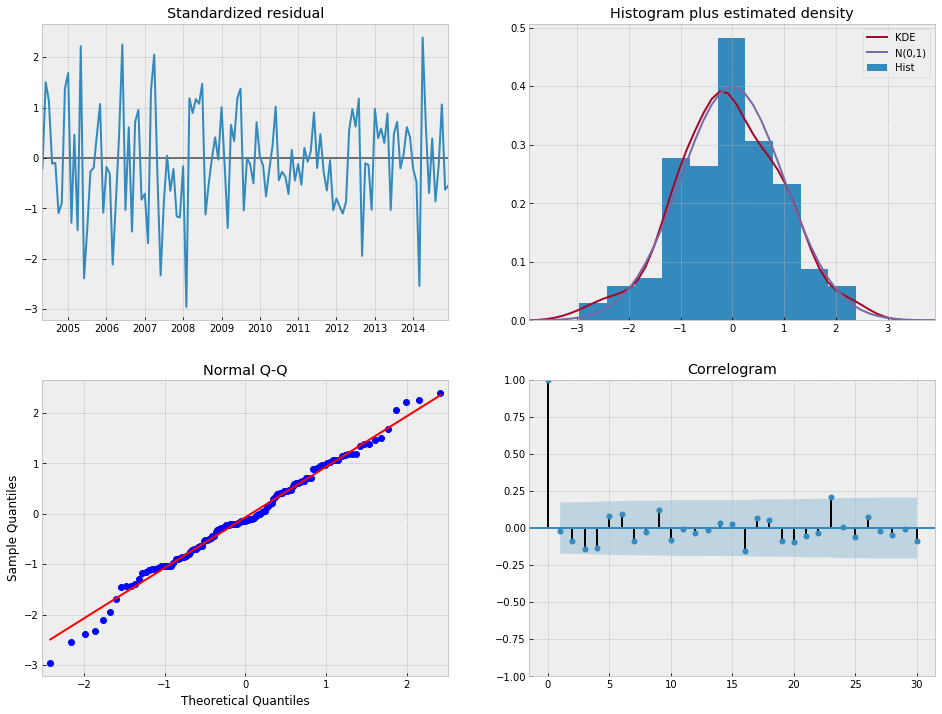

In [82]:
best_results.plot_diagnostics(lags=30, figsize=(16,12))
plt.show()

We need to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If it is not that it signifies that the model can be further improved and we repeat the process with the residuals.
In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:
- The KDE plot of the residuals on the top right is almost similar with the normal distribution.
- The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.
- The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

Those observations coupled with the fact that there are no spikes outside the insignificant zone for both ACF and PACF plots lead us to conclude that that residuals are random with no information or juice in them and our model produces a satisfactory fit that could help us understand our time series data and forecast future values. It sems that our ARIMA model is working fine.

#### Step 10: Regression with ARIMA  (ARMAX/SARIMAX)
For the last 4 years, PowerHorse tractors is running an expensive marketing and farmer connect program to boost their sales. They are interested in learning the impact of this program on overall sales. As a data science consultant we are helping them with this effort. This is an interesting problem and requires a thorough analysis followed by creative solutions and scientific monitoring mechanism. To begin with we will build models based on regression with ARIMA errors and compare them with the pure play ARIMA model. This analysis will provide some clues towards effectiveness of the marketing program. However, this analysis will not be conclusive for finding shortcomings and enhancements for the program which will require further analysis and creative solutions.

In [86]:
import pandas as pd

In [97]:
mkt_sales_data = pd.read_csv('sales-and-marketing.csv')

In [98]:
mkt_sales_data.head(10)

,Time Period,Sales,Marketing Expense
0,Jan-11,397,486.64
1,Feb-11,400,501.80
2,Mar-11,498,437.09
3,Apr-11,536,565.16
4,May-11,596,744.15
5,Jun-11,591,548.74
6,Jul-11,651,650.21
7,Aug-11,654,777.51
8,Sep-11,509,547.11
9,Oct-11,437,382.81


In [99]:
# since the complete date was not mentioned, we assume that it was the first of every month
mkt_sales_data.set_index(pd.date_range(start='2011-01-01', freq='MS', periods=len(mkt_sales_data)), inplace=True)
mkt_sales_data.drop(['Time Period'], axis=1, inplace=True)
mkt_sales_data.rename(columns={'Sales':'Tractor-Sales'}, inplace=True)
mkt_sales_data.head(5)

,Tractor-Sales,Marketing Expense
2011-01-01,397,486.64
2011-02-01,400,501.80
2011-03-01,498,437.09
2011-04-01,536,565.16
2011-05-01,596,744.15


To begin with, we plot the following scatter plot of same months marketing expense and tractors sales.

In [100]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(mkt_sales_data['Tractor-Sales'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  1.434334
p-value                         0.997265
#lags Used                     10.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64


In [101]:
mkt_sales_data_diff = mkt_sales_data.diff(periods=1)
mkt_sales_data_diff.dropna(inplace=True)

In [102]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(mkt_sales_data_diff['Tractor-Sales'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -7.015650e+00
p-value                        6.743731e-10
#lags Used                     1.000000e+01
Number of Observations Used    3.600000e+01
Critical Value (1%)           -3.626652e+00
Critical Value (5%)           -2.945951e+00
Critical Value (10%)          -2.611671e+00
dtype: float64


The correlation for the previous quarter also shows non-existent correlation with sales. Now, let’s build a regression model with ARIMA error (ARIMAX) model for the current and previous months.

In [103]:
mkt_sales_data['Mkt_Exp_Lag_1'] = mkt_sales_data['Marketing Expense'].shift(1)
mkt_sales_data['Mkt_Exp_Lag_2'] = mkt_sales_data['Marketing Expense'].shift(2)
mkt_sales_data['Mkt_Exp_Lag_3'] = mkt_sales_data['Marketing Expense'].shift(3)
mkt_sales_data['Mkt_Exp_Lag_4'] = mkt_sales_data['Marketing Expense'].shift(4)

In [104]:
mkt_sales_data.head()

,Tractor-Sales,Marketing Expense,Mkt_Exp_Lag_1,Mkt_Exp_Lag_2,Mkt_Exp_Lag_3,Mkt_Exp_Lag_4
2011-01-01,397,486.64,NaN,NaN,NaN,NaN
2011-02-01,400,501.80,486.64,NaN,NaN,NaN
2011-03-01,498,437.09,501.80,486.64,NaN,NaN
2011-04-01,536,565.16,437.09,501.80,486.64,NaN
2011-05-01,596,744.15,565.16,437.09,501.80,486.64


In [105]:
import itertools
import sys

def auto_arima(timeseries, regressors=None, p=range(0, 2), d=range(0, 2), q=range(0, 2),
              P=range(0, 2), D=range(0, 1), Q=range(0, 2)):

    # Generate all different combinations of p, d and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]
    
    warnings.filterwarnings("ignore") # specify to ignore warning messages

    best_aic = np.inf
    best_pdq = None
    best_seasonal_pdq = None
    best_results = None

    for param in pdq:
        for param_seasonal in seasonal_pdq:

            try:
                temp_model = sm.tsa.statespace.SARIMAX(endog=timeseries,
                                                 exog=regressors,
                                                 order = param,
                                                 seasonal_order = param_seasonal,
                                                 enforce_stationarity=False,
                                                 enforce_invertibility=False)
                temp_results = temp_model.fit()

                # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
                if temp_results.aic < best_aic:
                    best_aic = temp_results.aic
                    best_pdq = param
                    best_seasonal_pdq = param_seasonal
                    best_results = temp_results
            except:
                #print("Unexpected error:", sys.exc_info()[0])
                continue
                
                

    print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))
    print(best_results.summary().tables[0])
    print(best_results.summary().tables[1])

In [106]:
mkt_sales_data.dropna(inplace=True)
mkt_sales_data.head()

,Tractor-Sales,Marketing Expense,Mkt_Exp_Lag_1,Mkt_Exp_Lag_2,Mkt_Exp_Lag_3,Mkt_Exp_Lag_4
2011-05-01,596,744.15,565.16,437.09,501.80,486.64
2011-06-01,591,548.74,744.15,565.16,437.09,501.80
2011-07-01,651,650.21,548.74,744.15,565.16,437.09
2011-08-01,654,777.51,650.21,548.74,744.15,565.16
2011-09-01,509,547.11,777.51,650.21,548.74,744.15


In [107]:
mkt_sales_data.corr()

,Tractor-Sales,Marketing Expense,Mkt_Exp_Lag_1,Mkt_Exp_Lag_2,Mkt_Exp_Lag_3,Mkt_Exp_Lag_4
Tractor-Sales,1.000000,0.807838,0.585169,0.262011,-0.056909,-0.257012
Marketing Expense,0.807838,1.000000,0.626329,0.380395,0.140597,-0.130755
Mkt_Exp_Lag_1,0.585169,0.626329,1.000000,0.622385,0.380459,0.145967
Mkt_Exp_Lag_2,0.262011,0.380395,0.622385,1.000000,0.625423,0.398619
Mkt_Exp_Lag_3,-0.056909,0.140597,0.380459,0.625423,1.000000,0.634986
Mkt_Exp_Lag_4,-0.257012,-0.130755,0.145967,0.398619,0.634986,1.000000


In [108]:
#ARIMA Model with 2 months Lag Marekting Sales Data Regressor
timeseries = mkt_sales_data["Tractor-Sales"]
regressors = mkt_sales_data[["Marketing Expense", "Mkt_Exp_Lag_1", "Mkt_Exp_Lag_2"]]
best_results = auto_arima(timeseries, regressors, p=range(0, 2), d=range(0, 2), q=range(0, 2),
                         P=range(0, 2), D=range(0, 1), Q=range(0, 2))

Best SARIMAX(0, 1, 1)x(1, 0, 1, 12)12 model - AIC:273.48438717743704
                                 Statespace Model Results                                 
Dep. Variable:                      Tractor-Sales   No. Observations:                   44
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -129.742
Date:                            Sat, 27 Jul 2019   AIC                            273.484
Time:                                    12:27:02   BIC                            283.055
Sample:                                05-01-2011   HQIC                           276.482
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Marketing Expense     0.0287   

In [109]:
best_model = sm.tsa.statespace.SARIMAX(timeseries,
                                      exog = regressors,
                                      order=(1, 1, 0),
                                      seasonal_order=(1, 0, 0, 12),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
best_results = best_model.fit()

In [110]:
print(best_results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                      Tractor-Sales   No. Observations:                   44
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -135.148
Date:                            Sat, 27 Jul 2019   AIC                            282.295
Time:                                    12:27:09   BIC                            290.702
Sample:                                05-01-2011   HQIC                           284.985
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Marketing Expense     0.0016      0.041      0.040      0.968      -0.080       0.083
Mkt_Exp_Lag_1 

In [111]:
mkt_sales_data

,Tractor-Sales,Marketing Expense,Mkt_Exp_Lag_1,Mkt_Exp_Lag_2,Mkt_Exp_Lag_3,Mkt_Exp_Lag_4
2011-05-01,596,744.15,565.16,437.09,501.80,486.64
2011-06-01,591,548.74,744.15,565.16,437.09,501.80
2011-07-01,651,650.21,548.74,744.15,565.16,437.09
2011-08-01,654,777.51,650.21,548.74,744.15,565.16
2011-09-01,509,547.11,777.51,650.21,548.74,744.15
2011-10-01,437,382.81,547.11,777.51,650.21,548.74
2011-11-01,406,551.56,382.81,547.11,777.51,650.21
2011-12-01,470,401.69,551.56,382.81,547.11,777.51
2012-01-01,428,370.97,401.69,551.56,382.81,547.11
2012-02-01,423,318.39,370.97,401.69,551.56,382.81


In [112]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2014-01-01'), full_results=True)

pred_dynamic.predicted_mean

2014-01-01    532.391295
2014-02-01    528.597682
2014-03-01    641.437131
2014-04-01    659.654426
2014-05-01    782.822453
2014-06-01    768.296022
2014-07-01    858.327969
2014-08-01    875.595193
2014-09-01    649.548058
2014-10-01    564.844682
2014-11-01    537.329170
2014-12-01    625.703260
Freq: MS, dtype: float64

In [113]:
forecast = pred_dynamic.predicted_mean
actual = mkt_sales_data['2014-01-01':]['Tractor-Sales']

In [114]:
actual

2014-01-01    525
2014-02-01    520
2014-03-01    587
2014-04-01    710
2014-05-01    793
2014-06-01    749
2014-07-01    871
2014-08-01    848
2014-09-01    640
2014-10-01    581
2014-11-01    519
2014-12-01    605
Freq: MS, Name: Tractor-Sales, dtype: int64

In [115]:
MAPE_last1year = np.mean(np.abs(actual - forecast)/actual)

print('The Mean Absolute percentage error of our forecast for last two years is {}'.format(round(MAPE_last1year, 4)))

The Mean Absolute percentage error of our forecast for last two years is 0.0327


In [116]:
# Compute the mean square error
mse = ((actual - forecast) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))
print('The ROOT Mean Squared Error of our forecasts is {}'.format(np.sqrt(round(mse, 4))))

The Mean Squared Error of our forecasts is 678.4472
The ROOT Mean Squared Error of our forecasts is 26.04701902329708


In [117]:
#Forecast future

In [118]:
Future_mkt_spend = {
    '2015-01-01' : [600, 559.75, 527.60],
    '2015-02-01' : [550, 600, 559.75],
    '2015-03-01' : [700, 550, 600],
    '2015-04-01' : [590, 700, 550],
    '2015-05-01' : [480, 590, 700],
    '2015-06-01' : [520, 480, 590],
    '2015-07-01' : [800, 520, 480],
    '2015-08-01' : [675, 800, 520],
    '2015-09-01' : [820, 675, 800],
    '2015-10-01' : [710, 820, 675],
    '2015-11-01' : [550, 710, 820],
    '2015-12-01' : [590, 550, 710]
}

In [119]:
Future_mkt_spend = pd.DataFrame(Future_mkt_spend).T

In [120]:
Future_mkt_spend.columns = ['Marketing Expense', 'Mkt_Exp_Lag_1', 'Mkt_Exp_Lag_2']

In [121]:
Future_mkt_spend

,Marketing Expense,Mkt_Exp_Lag_1,Mkt_Exp_Lag_2
2015-01-01,600.0,559.75,527.60
2015-02-01,550.0,600.00,559.75
2015-03-01,700.0,550.00,600.00
2015-04-01,590.0,700.00,550.00
2015-05-01,480.0,590.00,700.00
2015-06-01,520.0,480.00,590.00
2015-07-01,800.0,520.00,480.00
2015-08-01,675.0,800.00,520.00
2015-09-01,820.0,675.00,800.00
2015-10-01,710.0,820.00,675.00


In [123]:
#Forecast for next 12 Months
best_results.forecast(steps=12, exog=Future_mkt_spend)

2015-01-01    562.280027
2015-02-01    559.482882
2015-03-01    628.947676
2015-04-01    775.317136
2015-05-01    863.217368
2015-06-01    824.207617
2015-07-01    978.246619
2015-08-01    956.313065
2015-09-01    705.383957
2015-10-01    635.024932
2015-11-01    553.749842
2015-12-01    649.498406
Freq: MS, dtype: float64

In [124]:
#### Step 8: Forecast sales using the best fit ARIMA model
#The next step is to predict tractor sales for next 6 Months through the above model.

# Get forecast 12 steps (12 Months) ahead in future
n_steps = 12
pred_uc_99 = best_results.get_forecast(steps=12, alpha=0.01, exog=Future_mkt_spend) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=12, alpha=0.05, exog=Future_mkt_spend) # alpha=0.05 95% CI

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [125]:
n_steps = 12
idx = pd.date_range(mkt_sales_data.index[-1], periods=n_steps, freq='MS')
fc_95 = pd.DataFrame(np.column_stack([pred_uc_95.predicted_mean, pred_ci_95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])

fc_99 = pd.DataFrame(np.column_stack([pred_ci_99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all.head()

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
2014-12-01,562.280027,519.378936,605.181119,519.378936,605.181119
2015-01-01,559.482882,512.541397,606.424367,512.541397,606.424367
2015-02-01,628.947676,571.961450,685.933902,571.961450,685.933902
2015-03-01,775.317136,713.112297,837.521974,713.112297,837.521974
2015-04-01,863.217368,794.569088,931.865648,794.569088,931.865648


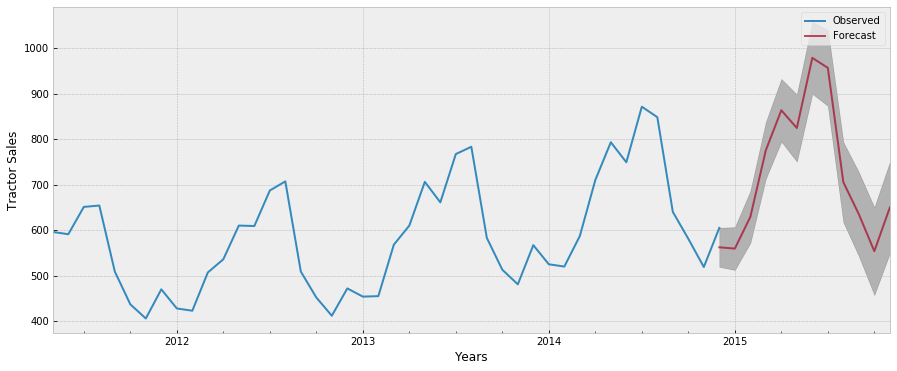

In [126]:
# plot the forecast along with the confidence band
axis = mkt_sales_data['Tractor-Sales'].plot(label='Observed', figsize=(15, 6))
fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
#axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=.25)
axis.fill_between(fc_all.index, fc_all['lower_ci_99'], fc_all['upper_ci_99'], color='k', alpha=.25)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()

In [121]:
#Diagnostics
    #1. Errors follows normality
    #2. Errors should not have auto correlation (ACF, no spikes beyond the limits)
    #3. Errors should not have any spikes (if the spikes are present, that particular time period, model didn't predict propoerly)


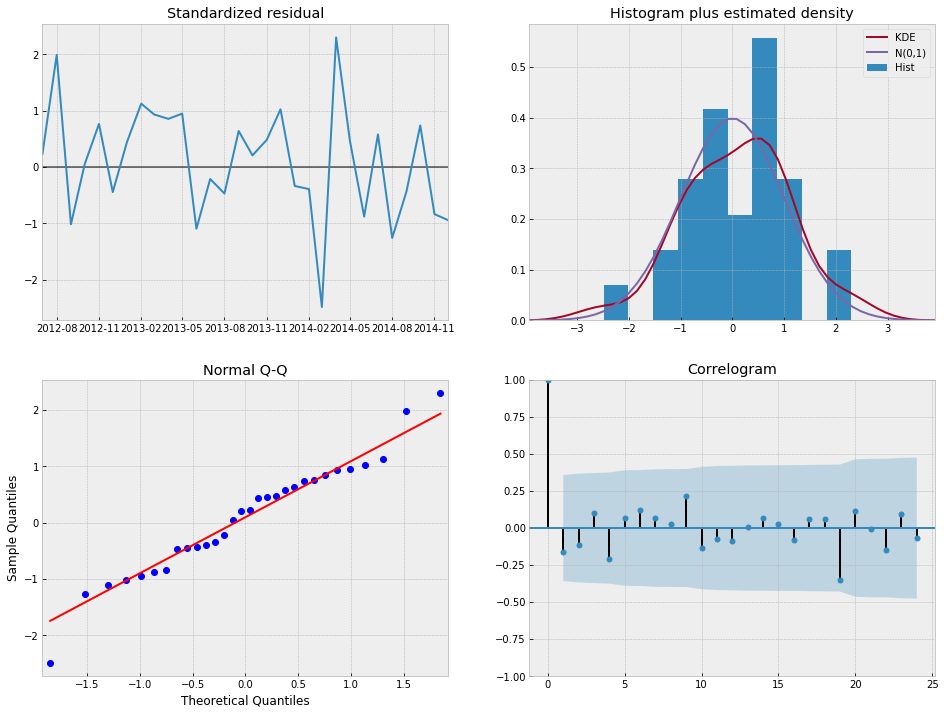

In [122]:
best_results.plot_diagnostics(lags=24, figsize=(16,12))
plt.show()

# Timeseries Forecasting using FBProphet

Released by Facebook in 2017, forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running.

In [37]:
#!conda  install -c conda-forge fbprophet --yes
#!pip install fbprophet
from fbprophet import Prophet #you need to install fbprophet using pip install

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [38]:
sales_data['ds'] = sales_data.index

In [39]:
sales_data.head()

,Month,Year,Tractor-Sales,ds
2003-01-01,Jan,2003,141,2003-01-01
2003-02-01,Feb,2003,157,2003-02-01
2003-03-01,Mar,2003,185,2003-03-01
2003-04-01,Apr,2003,199,2003-04-01
2003-05-01,May,2003,203,2003-05-01


In [40]:
sales_data = sales_data[['ds', 'Tractor-Sales']].rename(columns={'ds': 'ds', 'Tractor-Sales': 'y'})

In [51]:
Prophet?

In [52]:
sales_model = Prophet(seasonality_mode='multiplicative',interval_width=0.99)
sales_model.fit(sales_data)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sb/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [53]:
sales_forecast = sales_model.make_future_dataframe(periods=36, freq='MS')
sales_forecast = sales_model.predict(sales_forecast)

In [54]:
sales_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2003-01-01,159.231287,95.044191,168.041033,159.231287,159.231287,-0.178238,-0.178238,-0.178238,-0.178238,-0.178238,-0.178238,0.0,0.0,0.0,130.850167
1,2003-02-01,161.537502,98.667019,168.673486,161.537502,161.537502,-0.180181,-0.180181,-0.180181,-0.180181,-0.180181,-0.180181,0.0,0.0,0.0,132.431583
2,2003-03-01,163.620535,124.747898,203.337487,163.620535,163.620535,-0.011442,-0.011442,-0.011442,-0.011442,-0.011442,-0.011442,0.0,0.0,0.0,161.748318
3,2003-04-01,165.926750,145.299324,221.034832,165.926750,165.926750,0.103056,0.103056,0.103056,0.103056,0.103056,0.103056,0.0,0.0,0.0,183.026493
4,2003-05-01,168.158571,167.496314,239.113546,168.158571,168.158571,0.204115,0.204115,0.204115,0.204115,0.204115,0.204115,0.0,0.0,0.0,202.482281
5,2003-06-01,170.464786,157.956508,227.914453,170.464786,170.464786,0.135238,0.135238,0.135238,0.135238,0.135238,0.135238,0.0,0.0,0.0,193.518041
6,2003-07-01,172.696607,184.072833,257.538740,172.696607,172.696607,0.263733,0.263733,0.263733,0.263733,0.263733,0.263733,0.0,0.0,0.0,218.242330
7,2003-08-01,175.002823,183.012513,254.548570,175.002823,175.002823,0.250337,0.250337,0.250337,0.250337,0.250337,0.250337,0.0,0.0,0.0,218.812565
8,2003-09-01,177.309038,135.495389,206.069478,177.309038,177.309038,-0.032049,-0.032049,-0.032049,-0.032049,-0.032049,-0.032049,0.0,0.0,0.0,171.626431
9,2003-10-01,179.540859,119.851743,191.549183,179.540859,179.540859,-0.150336,-0.150336,-0.150336,-0.150336,-0.150336,-0.150336,0.0,0.0,0.0,152.549461


<Figure size 1296x432 with 0 Axes>

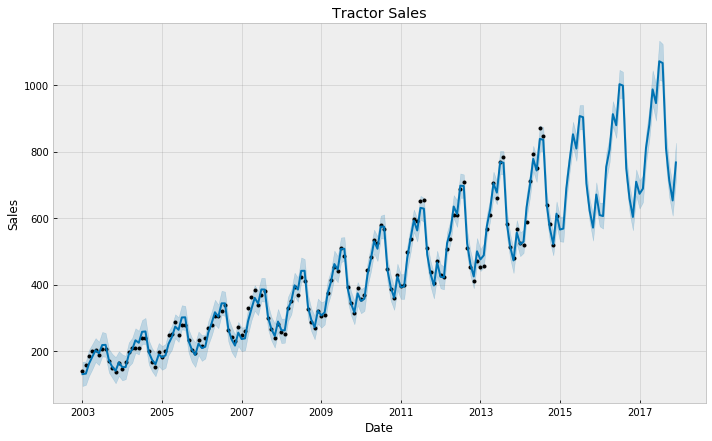

In [55]:
plt.figure(figsize=(18, 6))
sales_model.plot(sales_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Tractor Sales');

#### Trends and Patterns
Now, we can use the Prophet Models to inspect different trends of these two categories in the data.

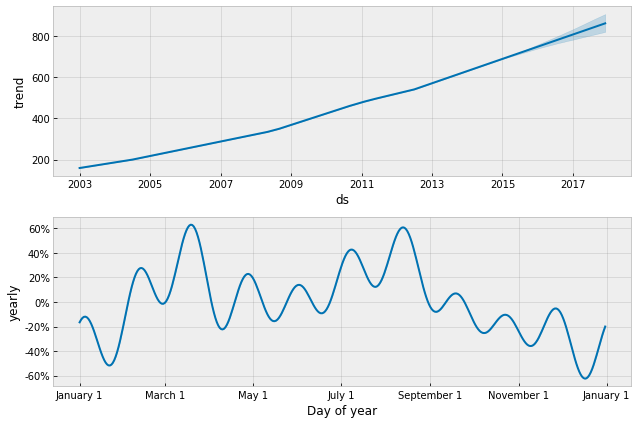

In [56]:
sales_model.plot_components(sales_forecast);

Good to see that the tractor sales have been linearly increasing over time 

The worst months for tractor sales are November, December and January. The best months for tractor sales are july and august.